# CycleGAN

Based on:
 - https://github.com/AYLIEN/gan-intro/blob/master/gan.py
 - https://hardikbansal.github.io/CycleGANBlog/

Dataset:
 - http://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/assignments/a4-code.zip

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#tf.enable_eager_execution()
#tf.executing_eagerly()

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

Import and preview the Apple and Windows emojis dataset.

In [2]:
def _parse_function(filename):
    """ Get tensor from filename """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=4) # RGBA images
    # They're probably already all 72x72, but just to make sure -- causes issues?
    #image_resized = tf.image.resize_images(image_decoded, [72, 72])
    # Normalize to be between -1 and 1
    image_cast = tf.cast(image_decoded, tf.float32)
    image_norm = tf.subtract(tf.divide(image_cast, [127.5]), 1)
    return image_norm

def train_input_fn(num_epochs=1, batch_size=1):
    """ Get tensors of training data for image sets A and B """
    apple = tf.data.Dataset.list_files("emojis/Apple/*.png").map(_parse_function)
    windows = tf.data.Dataset.list_files("emojis/Windows/*.png").map(_parse_function)
    
    apple_iter = apple.shuffle(num_epochs).repeat().batch(batch_size).make_one_shot_iterator()
    windows_iter = windows.shuffle(num_epochs).repeat().batch(batch_size).make_one_shot_iterator()
    return {
        'A': apple_iter.get_next(),
        'B': windows_iter.get_next()
    }

def test_input_fn(num_epochs=1, batch_size=1):
    """ Get tensors of testing data for image sets A and B """
    apple = tf.data.Dataset.list_files("emojis/Test_Apple/*.png").map(_parse_function)
    windows = tf.data.Dataset.list_files("emojis/Test_Windows/*.png").map(_parse_function)
    
    apple_iter = apple.shuffle(num_epochs).repeat().batch(batch_size).make_one_shot_iterator()
    windows_iter = windows.shuffle(num_epochs).repeat().batch(batch_size).make_one_shot_iterator()
    return {
        'A': apple_iter.get_next(),
        'B': windows_iter.get_next()
    }

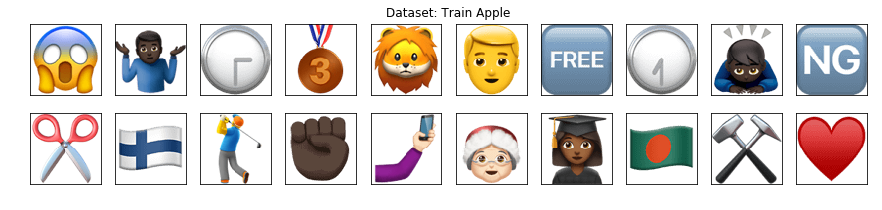

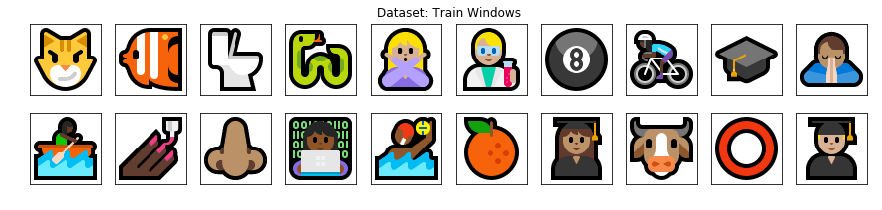

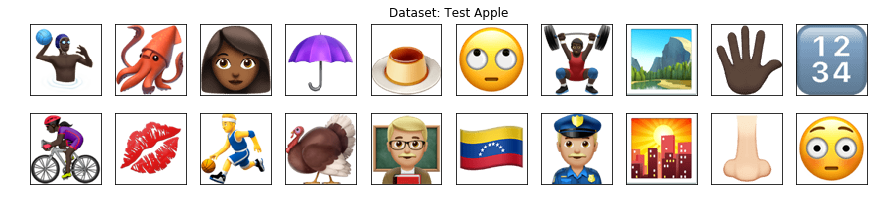

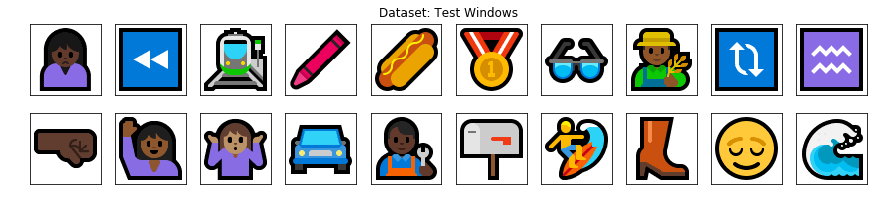

In [3]:
def show(titles, input_data, num=20, cols=10):
    with tf.Session() as sess:
        """ Display the first images in a given dataset as a sanity check """
        assert len(titles) == len(input_data)
        for i, (name,tensor) in enumerate(input_data.items()): # Plot each provided dataset (probably 2)
            fig = plt.figure(figsize=(15, 3))
            plt.axis('off')
            plt.title("Dataset: "+titles[i])
            
            # If we don't denormalize it, the coloring will be off
            denormalized = tf.cast(tf.multiply(tf.add(tensor,1),127.5), tf.uint8)

            for j in range(num):
                next_image = sess.run(denormalized)[0] # Only take first image in batch

                ax = fig.add_subplot(np.ceil(num/cols), cols, j+1)
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(next_image)

        plt.show()

show(["Train Apple", "Train Windows"], train_input_fn())
show(["Test Apple", "Test Windows"], test_input_fn())

Implementing the GAN

In [4]:
#
# CNN layers / blocks
#
def conv2d(name, inputs, num_outputs, kernel_size, stride, padding, stddev=0.02, activation=tf.nn.relu):
    with tf.variable_scope(name):
        return tf.contrib.layers.conv2d(inputs, num_outputs, kernel_size, stride, padding,
                                        activation_fn=activation,
                                        weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                        biases_initializer=tf.constant_initializer(0.0))

def deconv2d(name, inputs, num_outputs, kernel_size, stride, padding, stddev=0.02, activation=tf.nn.relu):
    with tf.variable_scope(name):
        return tf.contrib.layers.conv2d_transpose(inputs, num_outputs, kernel_size, stride, padding,
                                                  activation_fn=activation,
                                                  weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                                  biases_initializer=tf.constant_initializer(0.0))

def resnet(name, inputs, num_outputs):
    with tf.variable_scope(name):
        r = tf.pad(inputs, [[0,0], [1,1], [1,1], [0,0]], "REFLECT")
        r = conv2d("c1", r, num_outputs, 3, 1, "VALID")
        r = tf.pad(r, [[0,0], [1,1], [1,1], [0,0]], "REFLECT")
        r = conv2d("c2", r, num_outputs, 3, 1, "VALID", activation=None)
        return tf.nn.relu(r + inputs)

#
# Create networks
#
def create_generator(name, params, input_layer):
    l = tf.keras.layers
    batch_size = params['batch_size']
    w = params['img_width']
    h = params['img_height']
    layers = params['img_layers']
    ngf = 8 # Filter depth for generator, what was used in tutorial
    
    with tf.variable_scope(name):
        # TODO
        # - add instance norm, batch norm, group norm or something
        # - add leaky ReLU
        # - wrong sizes I think, so this probably won't work
        #input_layer = tf.placeholder(tf.float32, [batch_size, w, h layers], name=input_name)
        
        g_c1 = conv2d("c1", input_layer, ngf,   7, 1, "VALID")
        g_c2 = conv2d("c2", g_c1,        ngf*2, 3, 2, "SAME")
        g_c3 = conv2d("c3", g_c2,        ngf*4, 3, 1, "SAME")
        
        assert params['generator_residual_blocks'] > 0
        g_r = resnet("r1", g_c3, ngf*4)
        for i in range(params['generator_residual_blocks']-1):
            g_r = resnet("r"+str(i+2), g_r, ngf*4)
            
        g_c4 = deconv2d("c4", g_r,  ngf*2,  3, 2, "SAME")
        g_c5 = deconv2d("c5", g_c4, ngf,    3, 2, "SAME")
        g_c6 = conv2d("c6",   g_c5, layers, 3, 2, "SAME", activation=None)
        
        return tf.nn.tanh(g_c6, "t1") # Maybe not needed since I used ReLU for all of them?

def create_discriminator(name, params, input_layer):
    l = tf.keras.layers
    batch_size = params['batch_size']
    w = params['img_width']
    h = params['img_height']
    layers = params['img_layers']
    ndf = 16 # Filter depth for discriminator, what was used in tutorial
    
    with tf.variable_scope(name):
        d_c1 = conv2d("c1", input_layer, ndf,   4, 2, "SAME")
        d_c2 = conv2d("c2", d_c1,        ndf*2, 4, 2, "SAME")
        d_c3 = conv2d("c3", d_c2,        ndf*4, 4, 2, "SAME")
        d_c4 = conv2d("c4", d_c3,        ndf*8, 4, 1, "SAME")
        d_c5 = conv2d("c5", d_c4,        1,     4, 1, "SAME", activation=None)
        
        return d_c5

#
# Training interface with tf Estimator
#
def cyclegan_model(features, labels, mode, params):
    # Get image data directly from features or from "image" if it's a dictionary
    assert isinstance(features, dict) and len(features) == 2, "Features must include both images A and B"
    image_A = features['A']
    image_B = features['B']
    
    # Create models
    with tf.variable_scope("Model") as scope:
        # Generator on original images
        gen_AtoB = create_generator("gen_AtoB", params, image_A)
        gen_BtoA = create_generator("gen_BtoA", params, image_B)
        
        # Discriminator on the original real images
        disc_Areal = create_discriminator("discrim_A", params, image_A)
        disc_Breal = create_discriminator("discrim_B", params, image_B)
        
        scope.reuse_variables()
        
        # Generate from fake back to original (for cycle consistency)
        gen_AtoBtoA = create_generator("gen_BtoA", params, gen_AtoB) # Reuse weights from BtoA
        gen_BtoAtoB = create_generator("gen_AtoB", params, gen_BtoA) # Reuse weights from AtoB
        
        # Discriminators on the generated fake images
        disc_Afake = create_discriminator("discrim_A", params, gen_AtoB)
        disc_Bfake = create_discriminator("discrim_B", params, gen_BtoA)
        
        # TODO
        # - implement the image pool for performance and better convergence
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        raise RuntimeError("PREDICT not implemented")
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.PREDICT,
            predictions=predictions,
            export_outputs={
                'classify': tf.estimator.export.PredictOutput(predictions)
            })
    elif mode == tf.estimator.ModeKeys.TRAIN:
        #
        # Loss functions
        #
        # Generator should by cycle consistent & we want the discriminator to output a 1, i.e. incorrect label
        cyc_loss = tf.reduce_mean(tf.abs(image_A-gen_AtoBtoA)) + tf.reduce_mean(tf.abs(image_B-gen_BtoAtoB))
        g_loss_A = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(disc_Afake,1))
        g_loss_B = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(disc_Bfake,1))

        # Discriminator should correctly classify the original real images and the generated fake images
        d_loss_A = (tf.reduce_mean(tf.square(disc_Afake)) + tf.reduce_mean(tf.squared_difference(disc_Areal,1)))/2
        d_loss_B = (tf.reduce_mean(tf.square(disc_Bfake)) + tf.reduce_mean(tf.squared_difference(disc_Breal,1)))/2
        
        #
        # Variables
        #
        variables = tf.trainable_variables()
        d_A_vars = [v for v in variables if 'discrim_A' in v.name]
        g_A_vars = [v for v in variables if 'gen_A' in v.name]
        d_B_vars = [v for v in variables if 'discrim_B' in v.name]
        g_B_vars = [v for v in variables if 'gen_B' in v.name]
        
        def _train():
            optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)
            step = tf.train.get_or_create_global_step()
            d_A_trainer = optimizer.minimize(d_loss_A, step, var_list=d_A_vars)
            d_B_trainer = optimizer.minimize(d_loss_B, step, var_list=d_B_vars)
            g_A_trainer = optimizer.minimize(g_loss_A, step, var_list=d_A_vars)
            g_B_trainer = optimizer.minimize(g_loss_B, step, var_list=d_B_vars)
            
            """
            # From: https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/contrib/gan/python/train.py#L669
            update_ops = set(ops.get_collection(ops.GraphKeys.UPDATE_OPS))
            all_gen_ops = set(ops.get_collection(ops.GraphKeys.UPDATE_OPS, gen_scope))
            all_dis_ops = set(ops.get_collection(ops.GraphKeys.UPDATE_OPS, dis_scope))
            gen_update_ops = list(all_gen_ops & update_ops)
            dis_update_ops = list(all_dis_ops & update_ops)
            
            return gen_update_ops, dis_update_ops
            """
            return d_A_trainer, d_B_trainer, g_A_trainer, g_B_trainer
        
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.TRAIN,
            loss=[g_loss_A,g_loss_B,d_loss_A,d_loss_B],
            train_op=_train)
    else:
        assert mode == tf.estimator.ModeKeys.EVAL
        raise RuntimeError("EVAL not implemented")

#
# Train / test
#
def run_gan(num_epochs=100, batch_size=16, img_width=72, img_height=72, img_layers=4):
    # Define the model
    gan = tf.estimator.Estimator(model_fn=cyclegan_model, params={
        'data_format': 'channels_last',
        'batch_size': batch_size,
        'img_width': img_width,
        'img_height': img_height,
        'img_layers': img_layers,
        'generator_residual_blocks': 3
    }, config=tf.estimator.RunConfig(
        tf_random_seed=seed,
        model_dir="model"
    ))

    # Train
    gan.train(input_fn=lambda: train_input_fn(num_epochs, batch_size))
    
    # Visually evaluate samples
    #predictions = gan.predict(input_fn=lambda: test_input_fn(num_epochs, batch_size))
    
    # TODO: Plot 'em

In [5]:
run_gan()

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0b5b5e37b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


TypeError: train_op must be Operation or Tensor, given: <function cyclegan_model.<locals>._train at 0x7f0b00024e18>